In [162]:
from smr import File
import numpy as np
from matplotlib import pyplot as plt


In [163]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1218_Adapt.smr'
# f_name = '/mnt/data/kkarbasi/SimpleSpike-Felix/Felix 2006.09.06/Felix 2006.09.06 1313 List.smr'
# f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091608/B091608_1306_AdaptForward.smr'
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Wyatt/W120308_2/W120308_2_1714_List.smr'

In [165]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 6)
Not implemented (type = 5)
Not implemented (type = 5)


In [166]:
voltage_chan = smr_content.get_channel(0)
# HE_chan = smr_content.get_channel(1)
# VE_chan = smr_content.get_channel(2)

In [167]:
voltage_chan.data.shape

(42923830,)

In [168]:
from kaveh.sorting.spikesorter import SimpleSpikeSorter
# Time range of data to process:
t_0 = 0 #s
t_end = 20 #s

idx_0 = int(np.round(t_0 / voltage_chan.dt))
idx_end = int(np.round(t_end / voltage_chan.dt))
prange = slice(idx_0, idx_end)
sss = SimpleSpikeSorter(voltage_chan.data[prange], voltage_chan.dt)
sss.run()

In [169]:
sss.dt

1.9999999999999998e-05

<IPython.core.display.Javascript object>


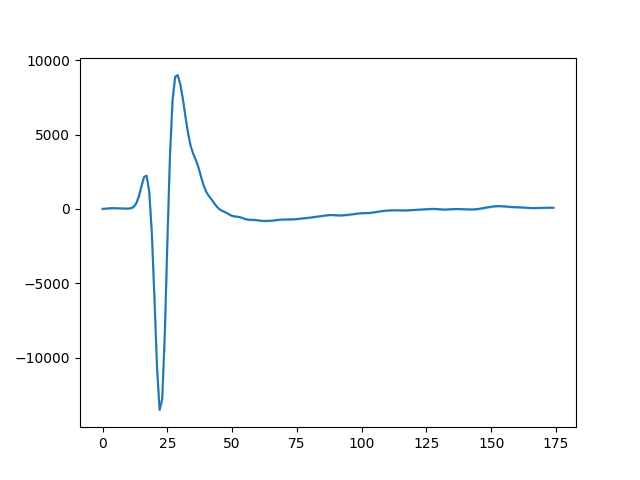

In [170]:
# Spike window (in seconds)
pre = 0.0005
post = 0.003

sss.set_spike_window(pre, post)
sss.plot_spike_waveforms_average()
# sss.plot_spike_peaks(figsize=(5,3))

In [ ]:
from neo.io import Spike2IO
from kaveh.toolbox import closest_argmin
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]
# Assuming cs spike trains are saved in the 0th index of spike train channels
cs_spiketrain = np.array(seg.spiketrains[0])
cs_spiketrain = np.int32(cs_spiketrain/sss.dt)
cs_spiketrain = cs_spiketrain[np.where(np.logical_and(cs_spiketrain >= idx_0, cs_spiketrain < idx_end))]
cs_spike_indices = np.unique(closest_argmin(cs_spiketrain, sss.spike_indices))

In [ ]:
np.asarray(seg.spiketrains[0])

In [ ]:
from kaveh.plots import axvlines
axvlines(plt.gca(), sss.spike_indices[cs_spike_indices], color='r', zorder=10)

In [ ]:
sss._align_spikes()
sss.plot_spike_waveforms_average()

pre_index = int(np.round(sss.pre_window / sss.dt))
post_index = int(np.round(sss.post_window / sss.dt))


cs_aligned_spikes = np.array([sss.voltage[i - pre_index : i + post_index ] for i in sss.spike_indices[cs_spike_indices]])

cs_spikes_avg = np.mean(cs_aligned_spikes, axis = 0)
cs_spikes_std = np.std(cs_aligned_spikes, axis = 0)/np.sqrt(cs_aligned_spikes.shape[0])
x = np.arange(0, cs_aligned_spikes.shape[1])

l = plt.plot(x, cs_spikes_avg, 'r')
plt.fill_between(x, cs_spikes_avg - cs_spikes_std, cs_spikes_avg + cs_spikes_std, color=l[0].get_color(), alpha=0.25)





In [ ]:
plt.figure()
plt.plot(cs_spikes_std)

# plt.figure()
plt.plot(np.std(sss.aligned_spikes, axis = 0)/np.sqrt(sss.aligned_spikes.shape[0]), 'r')

In [ ]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

In [ ]:
plt.figure()

for cs in cs_aligned_spikes:
    plt.plot(cs, alpha=0.10, color='k')
    
plt.plot(cs_spikes_avg, 'r')

plt.figure()

for ss in sss.aligned_spikes[0:100]:
        plt.plot(ss, alpha=0.10, color='k')
plt.plot(np.mean(sss.aligned_spikes[0:100], axis=0))


In [172]:
import scipy.fftpack
pre_index = int(np.round(sss.pre_window / sss.dt))
post_index = int(np.round(sss.post_window / sss.dt))

# y = sss.voltage[sss.spike_indices[cs_spike_indices[5]] - pre_index : sss.spike_indices[cs_spike_indices[5]] + post_index ]

# yf = scipy.fftpack.fft(y)


# N = y.size
# xf = np.linspace(0.0, 1.0/(2.0*sss.dt), N/2)

# # fig, ax = plt.subplots()
# plt.figure()
# plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# plt.show()
max_powers = []

import scipy.fftpack
for i in sss.spike_indices:


    y = sss.voltage[i - pre_index : i + post_index ]

    yf = scipy.fftpack.fft(y)


    N = y.size
    xf = np.linspace(0.0, 1.0/(2.0*sss.dt), N/2)

#     fig, ax = plt.subplots()

#     if np.max(2.0/N * np.abs(yf[:N//2]))>0:
#         plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    max_powers = max_powers + [np.max(2.0/N * np.abs(yf[:N//2]))]
#         print(i)
        

max_powers = np.asarray(max_powers)
   
# plt.show()

<IPython.core.display.Javascript object>


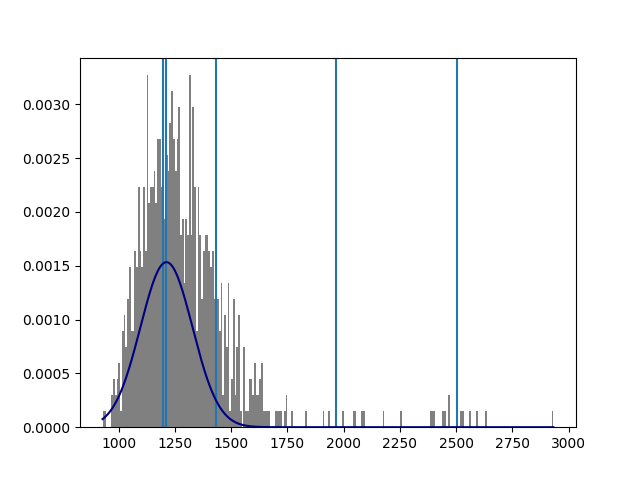

(14,)

In [173]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(5, covariance_type = 'tied').fit(max_powers.reshape(-1,1))

cluster_labels = gmm.predict(max_powers.reshape(-1,1))
cluster_labels = cluster_labels.reshape(max_powers.shape)

from scipy.stats import norm
from kaveh.plots import axvlines
plt.figure()
# uniq = np.unique(ss.d_voltage[prang] , return_counts=True)
x = np.arange(np.min(max_powers), np.max(max_powers), 1)
gauss_mixt = np.array([p * norm.pdf(x, mu, sd) for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_)])
colors = plt.cm.jet(np.linspace(0,1,len(gauss_mixt)))

# plot histogram overlaid by gmm gaussians
for i, gmixt in enumerate(gauss_mixt):
    plt.plot(x, gmixt, label = 'Gaussian '+str(i), color = colors[i])

plt.hist(max_powers.reshape(-1,1),bins=256,density=True, color='gray')
axvlines(plt.gca(), gmm.means_)
plt.show()


cs_indices = sss.spike_indices[cluster_labels == np.argmax(gmm.means_)]
cs_indices.shape

<IPython.core.display.Javascript object>


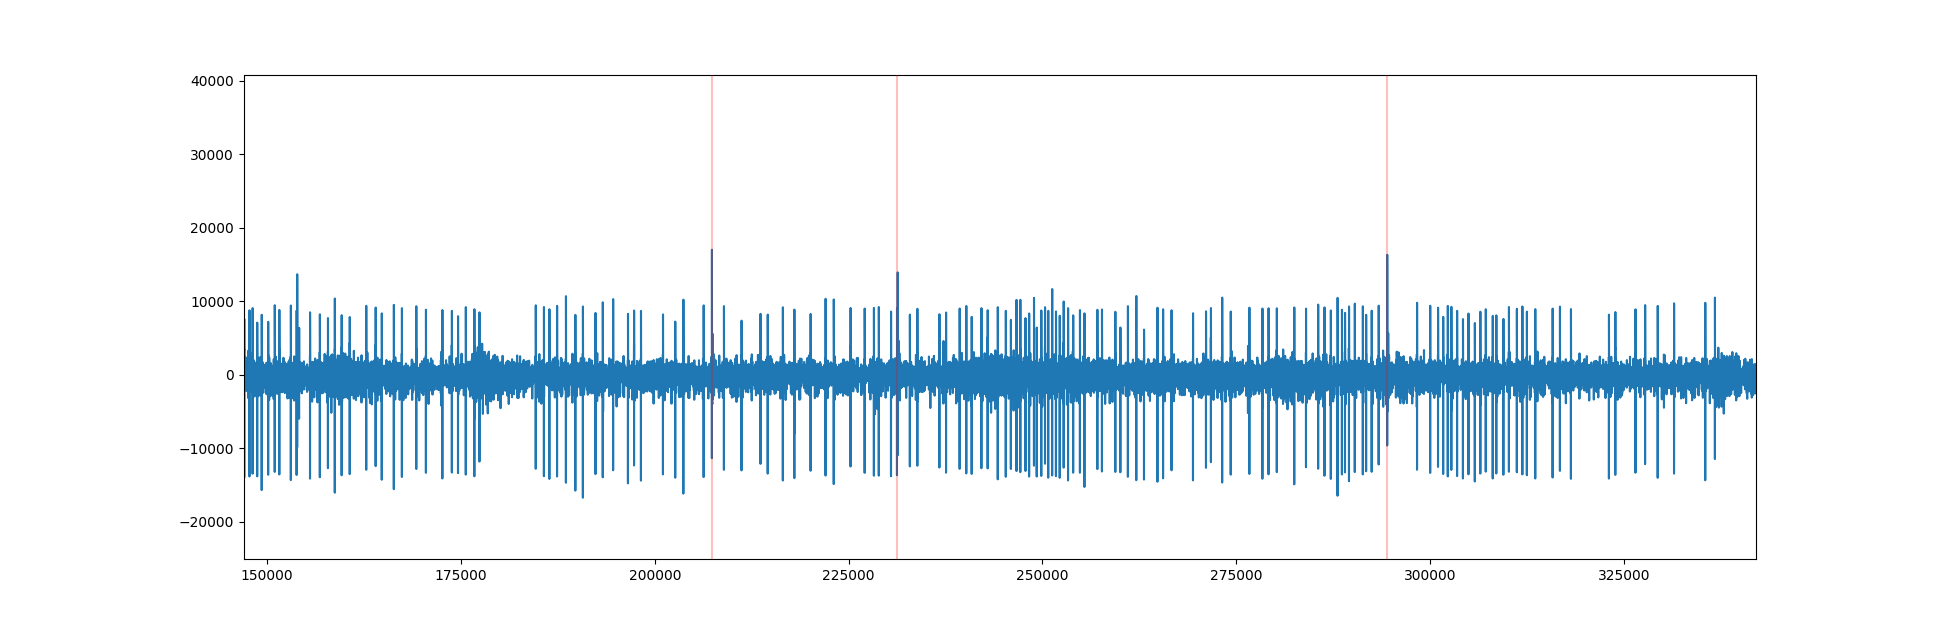

In [174]:
sss.plot_voltage(figsize=(5,3))

In [175]:
from kaveh.plots import axvlines
axvlines(plt.gca(), cs_indices, color='r', alpha=0.25, zorder=10)

In [98]:

aspikes = sss.aligned_spikes
aspikes[1:,:].shape

(12932, 175)

In [155]:
to_delete = []
for i, spike_index in enumerate(sss.spike_indices[1:]):
#     print(sss.spike_indices[i],spike_index)
    if (spike_index - pre_index) <=(sss.spike_indices[i] + post_index):
        to_delete = to_delete + [i]

print(to_delete)

[93, 137, 190, 1030, 1118, 1317, 1327, 1597, 2137, 2704, 3587, 3865, 3892, 4514, 5599, 6208, 6384, 6554, 6583, 6797, 7015, 7619, 7653, 8044, 8178, 8628, 9339, 9815, 10493, 10959, 11545, 11804, 12043, 12375]


In [157]:

mask = np.ones(sss.spike_indices.shape, dtype=bool)
mask[to_delete] = False
result = sss.spike_indices[mask]
# np.wheresss.spike_indices

In [161]:
print(result.shape)
print(sss.spike_indices.shape)
print(len(to_delete))

(12900,)
(12934,)
34


In [136]:
153877 - pre_index <= 153804 + post_index

True

In [141]:
sss.spike_indices[1:]

array([     937,     1629,     2319, ..., 14998493, 14999135, 14999991])

<IPython.core.display.Javascript object>


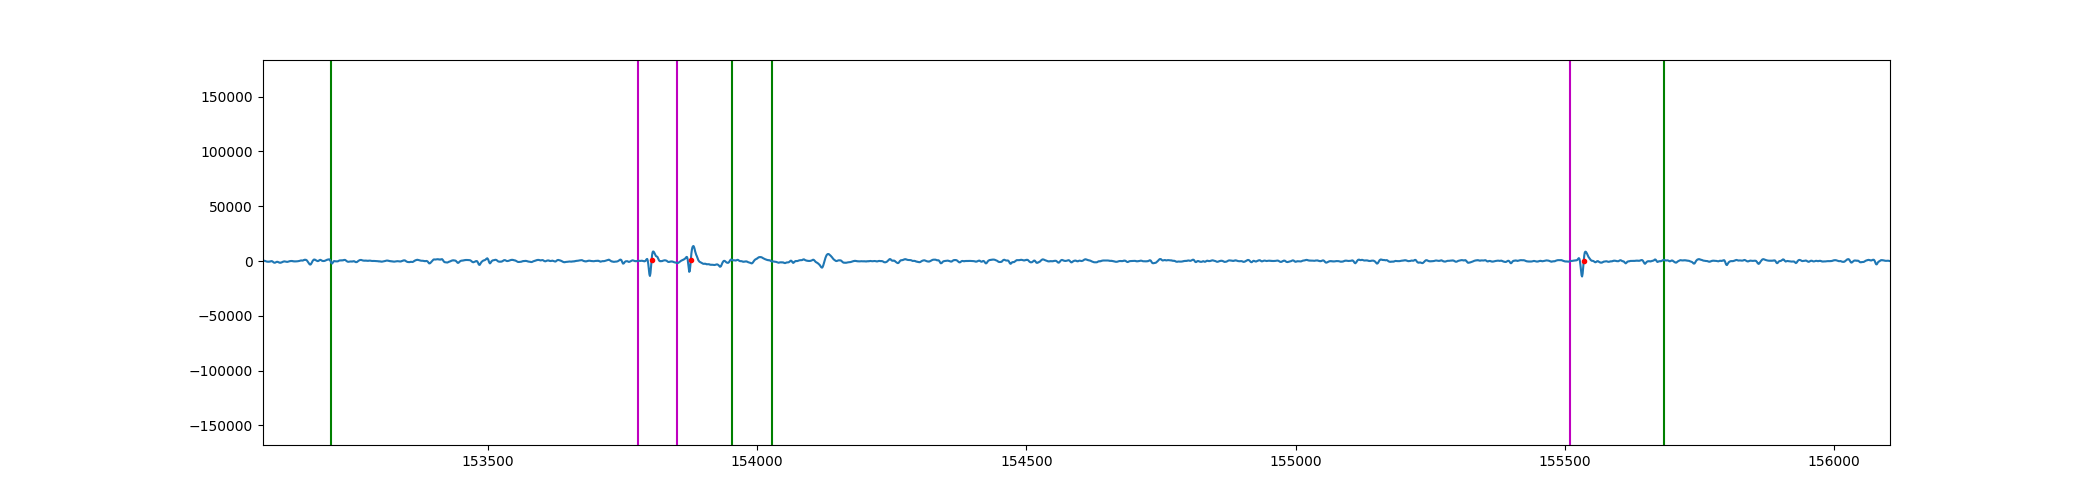

In [106]:
sss.plot_spike_peaks()